# Audio Retrieval
This notebooks demonstrates the process of the task and shows the results. 

## Task 1: Obtaining Data and Query Processing
We obtained the data from the MTG-Jamendo dataset. We used the 04 of the many tarballs available. The data can be downloaded [here](https://cdn.freesound.org/mtg-jamendo/raw_30s/audio/raw_30s_audio-04.tar). 

We randomly selected 20 tracks representing the query tracks. 
For each of the selected files, we extracted an approx. 10 sec segment starting at a random position within the first 20 seconds. We did this with other tools such as Audacity and FFmpeg (please see the folder `queries`for the corresponding .sh files used for automating the process).

We created differently distorted versions of the query tracks by applying the following transformations:
- Original: unmodified 10 sec segment
- Noise: added Gaussian noise to the segment
- Coding: compressed representation
- Mobile: outdoor recording with a mobile phone in an urban setting

The query tracks with the transformations are stored in the `queries` folder.
The MTG-Jamendo dataset provides mp3 files. We convert all `.mp3` files to `.wav` format because `.wav` provides lossless audio quality, ensuring more accurate spectrogram generation and audio analysis.

As a first step in this notebook. Let's create 2 methods to load the query and the data files.

In [1]:
import os

def get_data_files(directory='../data', endswith='.wav'):
    data_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(endswith):
                data_files.append(os.path.join(root, file))
    return data_files

def get_query_files(directory='../queries', endswith='.wav'):
    query_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(endswith):
                query_files.append(os.path.join(root, file))
    return query_files

In [2]:
print(get_query_files())

['../queries/cut_output/903604_cut.wav', '../queries/cut_output/1009604_cut.wav', '../queries/cut_output/1247404_cut.wav', '../queries/cut_output/1415804_cut.wav', '../queries/cut_output/1299504_cut.wav', '../queries/cut_output/1092304_cut.wav', '../queries/cut_output/1132204_cut.wav', '../queries/cut_output/1121404_cut.wav', '../queries/cut_output/1165404_cut.wav', '../queries/cut_output/1042004_cut.wav', '../queries/cut_output/1270604_cut.wav', '../queries/cut_output/863504_cut.wav', '../queries/cut_output/390004_cut.wav', '../queries/cut_output/1319504_cut.wav', '../queries/cut_output/1227104_cut.wav', '../queries/cut_output/1281204_cut.wav', '../queries/cut_output/3904_cut.wav', '../queries/cut_output/1110504_cut.wav', '../queries/cut_output/1300204_cut.wav', '../queries/cut_output/1330504_cut.wav', '../queries/coding_output/1121404_cut_coding.wav', '../queries/coding_output/1247404_cut_coding.wav', '../queries/coding_output/1227104_cut_coding.wav', '../queries/coding_output/113220

## Task 2: Database Preparation
For this task, we will create constellation maps for the first 30 seconds of each track in the database. The steps include:

1. Loading the first 30 seconds of audio files.
2. Computing the spectrograms using Short-Time Fourier Transform (STFT).
3. Generating constellation maps with different configurations for neighborhood parameters (`κ`, `τ`).
4. Storing the results in memory and optionally saving them to disk.

First let's define a helper method to compute and plot the constellation maps and compute the spectrogram.

In [3]:
import os, sys
import numpy as np
from numba import jit
import librosa
#from scipy import signal
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time

import libfmp.b
import libfmp.c2
import libfmp.c6


# Function to compute constellation map
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    result = ndimage.maximum_filter(Y, size=[2*dist_freq+1, 2*dist_time+1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

def plot_constellation_map(Cmap, Y=None, xlim=None, ylim=None, title='',
                           xlabel='Time (sample)', ylabel='Frequency (bins)',
                           s=5, color='r', marker='o', figsize=(7, 3), dpi=72):
    if Cmap.ndim > 1:
        (K, N) = Cmap.shape
    else:
        K = Cmap.shape[0]
        N = 1
    if Y is None:
        Y = np.zeros((K, N))
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    im = ax.imshow(Y, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    Fs = 1
    if xlim is None:
        xlim = [-0.5/Fs, (N-0.5)/Fs]
    if ylim is None:
        ylim = [-0.5/Fs, (K-0.5)/Fs]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    n, k = np.argwhere(Cmap == 1).T
    ax.scatter(k, n, color=color, s=s, marker=marker)
    plt.tight_layout()
    return fig, ax, im
    
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    #x, Fs = librosa.load(fn_wav, Fs)
    x, Fs = librosa.load(fn_wav, sr=Fs)
    x_duration = len(x) / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y
 

We will process the following configurations for the constellation map:

- `(κ=5, τ=3)`
- `(κ=7, τ=7)`
- `(κ=10, τ=5)`
- `(κ=15, τ=10)`

The files will be loaded from the folder `../data/04`.

In [15]:
# Example configurations
configurations = [
    (8, 2),  # (κ=8, τ=2)
    (11, 3),  # (κ=11, τ=3)
    (15, 4), # (κ=15, τ=4)
    (17, 5),  # (κ=17, τ=5)
]

# File list for processing
input_folder = "../data/04"
file_list = get_data_files(endswith=".mp3")

We will compute constellation maps for each file and configuration and store the results in memory. Optionally, the maps can be saved as `.npz` files for later use.

In [24]:


def prepare_database(file_list, configurations, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    """
    Prepares the database with metadata and constellation maps.

    Args:
        file_list (list): List of file paths to process.
        configurations (list of tuples): List of (dist_freq, dist_time) configurations.
        Fs (int): Sampling rate for spectrogram computation.
        N (int): FFT size.
        H (int): Hop size.
        bin_max (int): Maximum frequency bin for spectrogram.
        frame_max (int or None): Maximum number of frames for spectrogram.

    Returns:
        dict: A database dictionary with metadata and constellation maps.
    """
    database = {}

    for file in file_list:
        print(f"Processing file: {file}...")

        # Compute spectrogram for the current file
        Y = compute_spectrogram(file, Fs=Fs, N=N, H=H, bin_max=bin_max, frame_max=frame_max)

        # Retrieve metadata for the file
        file_size = os.path.getsize(file)  # Size in bytes
        duration = librosa.get_duration(path=file)  # Duration in seconds

        # Initialize nested structure for the current file
        file_key = os.path.basename(file)
        database[file_key] = {
            "metadata": {
                "size": file_size,
                "duration": duration,
            },
            "constellation_maps": {}
        }

        # Compute constellation maps for all configurations
        for (dist_freq, dist_time) in configurations:
            cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
            database[file_key]["constellation_maps"][(dist_freq, dist_time)] = cmap

    return database


# Prepare database
database = prepare_database(file_list, configurations)

Processing file: ../data/04/1143804.mp3...


/var/folders/y0/w7tkp5l134b35w384d72bs3c0000gn/T/ipykernel_1367/1609099110.py:27: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=file)  # Duration in seconds


Processing file: ../data/04/1302604.mp3...
Processing file: ../data/04/1178104.mp3...
Processing file: ../data/04/37804.mp3...
Processing file: ../data/04/1336204.mp3...
Processing file: ../data/04/1166104.mp3...
Processing file: ../data/04/229604.mp3...
Processing file: ../data/04/1397804.mp3...
Processing file: ../data/04/810904.mp3...
Processing file: ../data/04/1314304.mp3...
Processing file: ../data/04/1210604.mp3...
Processing file: ../data/04/225604.mp3...
Processing file: ../data/04/25804.mp3...
Processing file: ../data/04/1170404.mp3...
Processing file: ../data/04/1032804.mp3...
Processing file: ../data/04/1132804.mp3...
Processing file: ../data/04/80704.mp3...
Processing file: ../data/04/1326604.mp3...
Processing file: ../data/04/950104.mp3...
Processing file: ../data/04/1125404.mp3...
Processing file: ../data/04/1396104.mp3...
Processing file: ../data/04/1121104.mp3...
Processing file: ../data/04/152804.mp3...
Processing file: ../data/04/28104.mp3...
Processing file: ../data

We will visualize the constellation maps for the first file (with all the configurations) in the database. Each constellation map will show:

1. The spectrogram of the audio.
2. The detected peaks for one selected configuration.

This will help us verify that the constellation maps are being computed correctly.

{'metadata': {'size': 9201415, 'duration': 229.97043083900226}, 'constellation_maps': {(8, 2): array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), (11, 3): array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), (15, 4): array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       

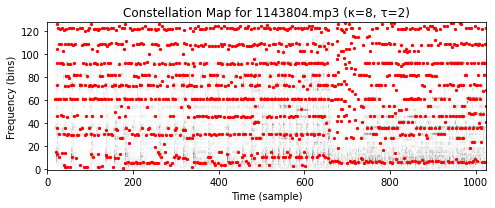

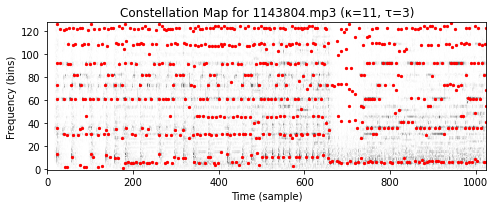

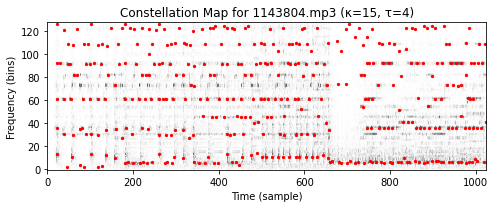

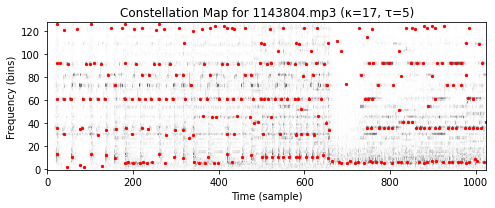

In [29]:
# Display constellation maps for the first file with all configurations
first_file = file_list[0]

# Compute the spectrogram for the first file
Y = compute_spectrogram(first_file, Fs=22050, N=2048, H=1024, bin_max=128)

# Plot constellation maps for all configurations
for dist_freq, dist_time in configurations:
    cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
    title = f"Constellation Map for {os.path.basename(first_file)} (κ={dist_freq}, τ={dist_time})"
    plot_constellation_map(cmap, Y=Y, title=title)


The generated constellation maps can be saved to disk for later use. Each map will be stored as an `.npz` file. (Optional)


In [25]:
output_folder = "constellations"
os.makedirs(output_folder, exist_ok=True)

for key, cmap in database.items():
    np.savez_compressed(os.path.join(output_folder, f"{key}.npz"), cmap=cmap)

print(f"Saved constellation maps to {output_folder}")


Saved constellation maps to constellations


## Task 3: Retrieval Experimentation
In this section, we perform retrieval experiments by:

1. Calculating constellation maps for the queries created in Task 1.
2. Comparing each query's constellation map with all maps in the database.
3. Identifying the best match by sliding the query constellation map over each database map and calculating the overlap.
4. Evaluating the performance of the retrieval system using true positives (TP), false positives (FP), and false negatives (FN).
5. Visualizing matching results and analyzing the impact of different tolerance settings (`tol_freq`, `tol_time`) and configurations (`κ`, `τ`).

The final results include:
- The file(s) with the highest match scores.
- Average query processing time.
- A table comparing performance metrics for various configurations and query distortions.

First again, let's define some helper methods to perform the retrieval experiments.




In [7]:
def compute_matching_function(C_D, C_Q, tol_freq=1, tol_time=1):
    L = C_D.shape[1]
    N = C_Q.shape[1]
    M = L - N
    assert M >= 0, "Query must be shorter than document"
    Delta = np.zeros(L)
    for m in range(M + 1):
        C_D_crop = C_D[:, m:m+N]
        TP, FN, FP, C_AND = match_binary_matrices_tol(C_D_crop, C_Q,
                                                      tol_freq=tol_freq, tol_time=tol_time)
        Delta[m] = TP
    shift_max = np.argmax(Delta)
    return Delta, shift_max


def match_binary_matrices_tol(C_ref, C_est, tol_freq=0, tol_time=0):
    assert C_ref.shape == C_est.shape, "Dimensions need to agree"
    N = np.sum(C_ref)
    M = np.sum(C_est)
    # Expand C_est with 2D-max-filter using the tolerance parameters
    C_est_max = ndimage.maximum_filter(C_est, size=(2*tol_freq+1, 2*tol_time+1),
                                       mode='constant')
    C_AND = np.logical_and(C_est_max, C_ref)
    TP = np.sum(C_AND)
    FN = N - TP
    FP = M - TP
    return TP, FN, FP, C_AND


First let's create the constellation maps for the query files. We will use the same configurations as before.

In [32]:
def prepare_query_constellation_maps(file_list, configurations, Fs=22050, N=2048, H=1024, bin_max=128, frame_max=None):
    """
    Prepares query constellation maps with metadata.

    Args:
        file_list (list): List of query file paths to process.
        configurations (list of tuples): List of (dist_freq, dist_time) configurations.
        Fs (int): Sampling rate for spectrogram computation.
        N (int): FFT size.
        H (int): Hop size.
        bin_max (int): Maximum frequency bin for spectrogram.
        frame_max (int or None): Maximum number of frames for spectrogram.

    Returns:
        dict: A query maps dictionary with metadata and constellation maps.
    """
    query_maps = {}

    for file in file_list:
        print(f"Processing file: {file}...")

        # Compute spectrogram for the current file
        Y = compute_spectrogram(file, Fs=Fs, N=N, H=H, bin_max=bin_max, frame_max=frame_max)

        # Retrieve metadata for the file
        file_size = os.path.getsize(file)  # Size in bytes
        duration = librosa.get_duration(path=file)  # Duration in seconds

        # Initialize nested structure for the current query
        file_key = os.path.basename(file)
        query_maps[file_key] = {
            "metadata": {
                "size": file_size,
                "duration": duration,
            },
            "constellation_maps": {}
        }

        # Compute constellation maps for all configurations
        for (dist_freq, dist_time) in configurations:
            cmap = compute_constellation_map(Y, dist_freq=dist_freq, dist_time=dist_time)
            query_maps[file_key]["constellation_maps"][(dist_freq, dist_time)] = cmap

    return query_maps

query_list = get_query_files()
query_constellation_maps = prepare_query_constellation_maps(query_list, configurations)
print(query_constellation_maps.keys())


Processing file: ../queries/cut_output/903604_cut.wav...
Processing file: ../queries/cut_output/1009604_cut.wav...
Processing file: ../queries/cut_output/1247404_cut.wav...
Processing file: ../queries/cut_output/1415804_cut.wav...
Processing file: ../queries/cut_output/1299504_cut.wav...
Processing file: ../queries/cut_output/1092304_cut.wav...
Processing file: ../queries/cut_output/1132204_cut.wav...
Processing file: ../queries/cut_output/1121404_cut.wav...
Processing file: ../queries/cut_output/1165404_cut.wav...
Processing file: ../queries/cut_output/1042004_cut.wav...
Processing file: ../queries/cut_output/1270604_cut.wav...
Processing file: ../queries/cut_output/863504_cut.wav...
Processing file: ../queries/cut_output/390004_cut.wav...
Processing file: ../queries/cut_output/1319504_cut.wav...
Processing file: ../queries/cut_output/1227104_cut.wav...
Processing file: ../queries/cut_output/1281204_cut.wav...
Processing file: ../queries/cut_output/3904_cut.wav...
Processing file: ../

Now, let's do a test for the first query file to the first database file.